This notebook investigates how deep we can make a neural network. Naive approach of simply adding 10 hidden layers (DeepNaiveNet) behaves worse (it has terrible performance in fact) than the network from tutorial (NaiveNet) with one hidden layer added. This is probably due to vanishing gradients. Adding BatchNorm layers and Residual Connections (you can look it up on Wikipedia if you don't know or ask ChatGPT--> They are modern algorithms that make possible training very deep models such as Transformers) results in the DeepNet model that converges to 100% test accuracy with less than 1000 epochs, whereas it takes NaiveNet about 6000 epochs to converge to 100% test accuracy. 

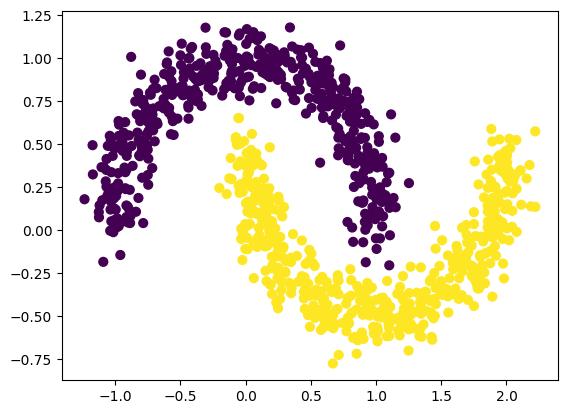

Size X_train: torch.Size([800, 2])
Size y_train: torch.Size([800])
Size X_test: torch.Size([200, 2])
Size y_test: torch.Size([200])


In [1]:
# @title Generate sample data
# @markdown we used `scikit-learn` module
from sklearn.datasets import make_moons
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

DEVICE='cuda'

def make_data():
    X_orig, y_orig = make_moons(1000, noise=0.1)

    # Visualize the dataset. The color of the points is determined by the labels `y_orig`.
    plt.scatter(X_orig[:, 0], X_orig[:, 1], s=40, c=y_orig)
    plt.show()

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.2, shuffle=True, stratify=y_orig)

    # Initialize the device variable
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Convert the 2D points to float32 tensors
    X_train = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)

    # Convert the labels to long integer tensors
    y_train = torch.tensor(y_train, dtype=torch.long).to(DEVICE)
    y_test = torch.tensor(y_test, dtype=torch.long).to(DEVICE)

    print(f"Size X_train: {X_train.shape}")
    print(f"Size y_train: {y_train.shape}")
    print(f"Size X_test: {X_test.shape}")
    print(f"Size y_test: {y_test.shape}")
    
    return X_train, y_train, X_test, y_test

# Example usage:
X_train, y_train, X_test, y_test = make_data()

In [2]:
# Implement the train function given a training dataset X and correcsponding labels y

# @title Helper function to plot the decision boundary

# Code adapted from this notebook: https://jonchar.net/notebooks/Artificial-Neural-Network-with-Keras/


def plot_decision_boundary(model, X, y, device):
  """
  Helper function to plot decision boundary

  Args:
    model: nn.module
      NaiveNet instance
    X: torch.tensor
      Input CIFAR10 data
    y: torch.tensor
      Class Labels/Targets
    device: String
      "cpu" or "cuda"

  Returns:
    Nothing
  """
  # Transfer the data to the CPU
  X = X.cpu().numpy()
  y = y.cpu().numpy()

  # Check if the frames folder exists and create it if needed
  #frames_path = Path("frames")
  #if not frames_path.exists():
    #frames_path.mkdir()

  # Set min and max values and give it some padding
  x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
  y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
  h = 0.01

  # Generate a grid of points with distance h between them
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Predict the function value for the whole gid
  grid_points = np.c_[xx.ravel(), yy.ravel()]
  grid_points = torch.from_numpy(grid_points).type(torch.FloatTensor)
  Z = model.predict(grid_points.to(device)).cpu().numpy()
  Z = Z.reshape(xx.shape)

  # Plot the contour and training examples
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)
    
def train(model, X, y, X_test, y_test):
  """
    Training the Neural Network

    Args:
      X: torch.Tensor
        Input data
      y: torch.Tensor
        Class Labels/Targets

    Returns:
      losses: Float
        Cross Entropy Loss; Cross-entropy builds upon the idea of entropy
        from information theory and calculates the number of bits required
        to represent or transmit an average event from one distribution
        compared to another distribution.
    """
  # The Cross Entropy Loss is suitable for classification problems
  loss_function = nn.CrossEntropyLoss()

  # Create an optimizer (Stochastic Gradient Descent) that will be used to train the network
  learning_rate = 1e-2
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  # Number of epochs
  epochs = 15000

  # List of losses for visualization
  losses = []

  for i in range(epochs):
    model.train()
    # Pass the data through the network and compute the loss
    # We'll use the whole dataset during the training instead of using batches
    # in to order to keep the code simple for now.
    y_logits = model.forward(X)
    loss = loss_function(y_logits, y)

    # Clear the previous gradients and compute the new ones
    optimizer.zero_grad()
    loss.backward()

    # Adapt the weights of the network
    optimizer.step()

    # Store the loss
    losses.append(loss.item())

    # Print the results at every 1000th epoch
    if i % 1000 == 0:
      print(f"Epoch {i} loss is {loss.item()}")

      plot_decision_boundary(model, X, y, DEVICE)
      #plt.savefig('frames/{:05d}.png'.format(i))
    
      test_acc=evaluate(model, X_test, y_test)
      print(f"Epoch {i} test accuracy is {test_acc}")

  return losses

def evaluate(model, X_test, y_test):
    """
    Evaluate the trained model on the test dataset.

    Args:
      model: torch.nn.Module
        The trained neural network model.
      X_test: torch.Tensor
        Test input data.
      y_test: torch.Tensor
        Test class labels/targets.

    Returns:
      accuracy: Float
        The accuracy of the model on the test dataset.
    """
    # Put the model in evaluation mode
    model.eval()

    # No need to compute gradients for evaluation
    with torch.no_grad():
        # Forward pass: compute the output
        y_logits = model.forward(X_test)
        
        # Get the predicted labels
        y_pred = torch.argmax(F.softmax(y_logits, dim=1), dim=1)
        
        # Calculate the accuracy
        accuracy = (y_pred == y_test).float().mean().item()
    model.train()
    #print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

    

NaiveNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)
Epoch 0 loss is 0.7258698344230652
Epoch 0 test accuracy is 0.5
Epoch 1000 loss is 0.29006704688072205
Epoch 1000 test accuracy is 0.8899999856948853
Epoch 2000 loss is 0.2171766608953476
Epoch 2000 test accuracy is 0.9199999570846558
Epoch 3000 loss is 0.1585753709077835
Epoch 3000 test accuracy is 0.949999988079071
Epoch 4000 loss is 0.09986366331577301
Epoch 4000 test accuracy is 0.98499995470047
Epoch 5000 loss is 0.06099994480609894
Epoch 5000 test accuracy is 0.9950000047683716
Epoch 6000 loss is 0.04075163975358009
Epoch 6000 test accuracy is 1.0
Epoch 7000 loss is 0.029951106756925583
Epoch 7000 test accuracy is 1.0
Epoch 8000 loss is 0.02356811799108982
Epoch 8000 test accuracy is 1.0
Epoch 9000 loss is 0.019461030140519142
Epoch 9

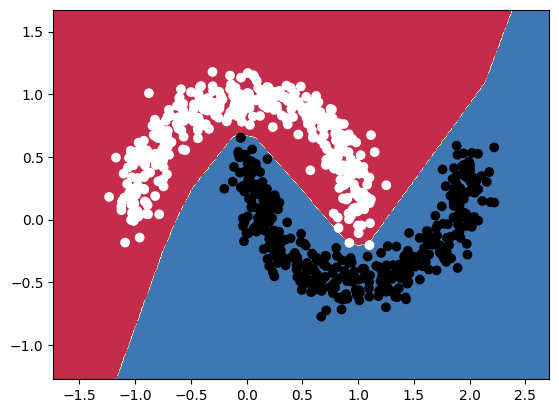

In [3]:
# Inherit from nn.Module - the base class for neural network modules provided by Pytorch
class NaiveNet(nn.Module):
  """
  NaiveNet architecture
  Structure is as follows:
  Linear Layer (2, 16) -> ReLU activation -> Linear Layer (16,16)-> ReLU activation -> Linear Layer (16, 2)
  """
  # Define the structure of your network
  def __init__(self):
    """
    Defines the NaiveNet structure by initialising following attributes
    nn.Linear (2, 16):  Transformation from the input to the hidden layer
    nn.ReLU: Activation function (ReLU) is a non-linearity which is widely used because it reduces computation.
             The function returns 0 if it receives any negative input, but for any positive value x, it returns that value back.
    nn.Linear (16, 2): Transformation from the hidden to the output layer

    Args:
      None

    Returns:
      Nothing
    """
    super(NaiveNet, self).__init__()

    # The network is defined as a sequence of operations
    self.layers = nn.Sequential(
        nn.Linear(2, 16),
        nn.ReLU(),
        nn.Linear(16,16),
        nn.ReLU(),
        nn.Linear(16, 2),
    )

  # Specify the computations performed on the data
  def forward(self, x):
    """
    Defines the forward pass through the above defined structure

    Args:
      x: torch.Tensor
        Input tensor of size ([3])

    Returns:
      layers: nn.module
        Initialised Layers in order to re-use the same layer for each forward pass of data you make.
    """
    # Pass the data through the layers
    return self.layers(x)

  # Choose the most likely label predicted by the network
  def predict(self, x):
    """
    Performs the prediction task of the network

    Args:
      x: torch.Tensor
        Input tensor of size ([3])

    Returns:
      Most likely class i.e., Label with the highest score
    """
    # Pass the data through the networks
    output = self.forward(x)

    # Choose the label with the highest score
    return torch.argmax(output, 1)

# Create new NaiveNet and transfer it to the device
model = NaiveNet().to(DEVICE)

# Print the structure of the network
print(model)

# Create a new network instance a train it
model = NaiveNet().to(DEVICE)
losses = train(model, X_train, y_train,X_test,y_test)

DeepNaiveNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=16, bias=True)
    (9): ReLU()
    (10): Linear(in_features=16, out_features=16, bias=True)
    (11): ReLU()
    (12): Linear(in_features=16, out_features=16, bias=True)
    (13): ReLU()
    (14): Linear(in_features=16, out_features=16, bias=True)
    (15): ReLU()
    (16): Linear(in_features=16, out_features=16, bias=True)
    (17): ReLU()
    (18): Linear(in_features=16, out_features=16, bias=True)
    (19): ReLU()
    (20): Linear(in_features=16, out_features=16, bias=True)
    (21): ReLU()
    (22): Linear(in_features=16, out_features=2, bias=True)
  )
)
Epoch 0 loss is 0.6931966543197632
Epoch 0 test a

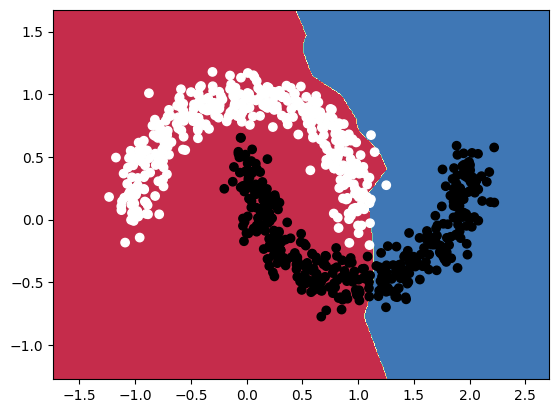

In [4]:
class DeepNaiveNet(nn.Module):
  """
  DeepNaiveNet architecture
  Structure is as follows:
  it has 10 linear layers of the same width after an encoder and before the decoder. 
  """
  # Define the structure of your network
  def __init__(self):
    """
    Defines the NaiveNet structure by initialising following attributes
    nn.Linear (2, 16):  Transformation from the input to the hidden layer
    nn.Linear (16,16): Hidden layer for connecting them in sequence 
    nn.ReLU: Activation function (ReLU) is a non-linearity which is widely used because it reduces computation.
             The function returns 0 if it receives any negative input, but for any positive value x, it returns that value back.
    nn.Linear (16, 2): Transformation from the hidden to the output layer

    Args:
      None

    Returns:
      Nothing
    """
    super(DeepNaiveNet, self).__init__()

    layers = []
    # Initial input layer
    layers.append(nn.Linear(2, 16))
    layers.append(nn.ReLU())

    # Add 99 layers of Linear + ReLU
    for _ in range(10):
        layers.append(nn.Linear(16, 16))
        layers.append(nn.ReLU())

    # Final output layer
    layers.append(nn.Linear(16, 2))

    # Create the sequential model
    self.layers = nn.Sequential(*layers
                               )
  # Specify the computations performed on the data
  def forward(self, x):
    """
    Defines the forward pass through the above defined structure

    Args:
      x: torch.Tensor
        Input tensor of size ([3])

    Returns:
      layers: nn.module
        Initialised Layers in order to re-use the same layer for each forward pass of data you make.
    """
    # Pass the data through the layers
    return self.layers(x)

  # Choose the most likely label predicted by the network
  def predict(self, x):
    """
    Performs the prediction task of the network

    Args:
      x: torch.Tensor
        Input tensor of size ([3])

    Returns:
      Most likely class i.e., Label with the highest score
    """
    # Pass the data through the networks
    output = self.forward(x)

    # Choose the label with the highest score
    return torch.argmax(output, 1)

# Create new NaiveNet and transfer it to the device
model = DeepNaiveNet().to(DEVICE)

# Print the structure of the network
print(model)
losses = train(model, X_train, y_train,X_test,y_test)

DeepNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ResidualBlock(
      (linear1): Linear(in_features=16, out_features=16, bias=True)
      (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (linear2): Linear(in_features=16, out_features=16, bias=True)
      (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): ResidualBlock(
      (linear1): Linear(in_features=16, out_features=16, bias=True)
      (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (linear2): Linear(in_features=16, out_features=16, bias=True)
      (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): ResidualBlock(
      (linear1): Linear(in_featur

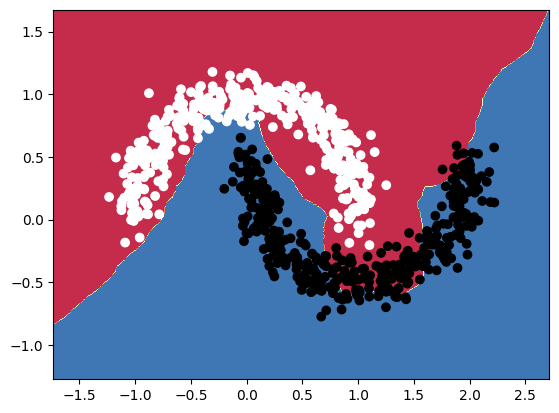

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(in_features, out_features)
        self.bn1 = nn.BatchNorm1d(out_features)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(out_features, out_features)
        self.bn2 = nn.BatchNorm1d(out_features)

    def forward(self, x):
        identity = x
        out = self.linear1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.bn2(out)
        out += identity  # Add the input (identity) to the output
        out = self.relu(out)
        return out

class DeepNet(nn.Module):
    """
    DeepNaiveNet architecture
    Structure is as follows:
    it has 10 linear layers interspersed with batchnorm and residual connections. 
    """
    # Define the structure of your network
    def __init__(self):
        super(DeepNet, self).__init__()
        layers = []
        # Initial input layer
        layers.append(nn.Linear(2, 16))
        layers.append(nn.BatchNorm1d(16))
        layers.append(nn.ReLU())

        for _ in range(5):
            layers.append(ResidualBlock(16, 16))

        # Final output layer
        layers.append(nn.Linear(16, 2))

        # Create the sequential model
        self.layers = nn.Sequential(*layers)
    # Specify the computations performed on the data
    def forward(self, x):
        """
        Defines the forward pass through the above defined structure

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          layers: nn.module
            Initialised Layers in order to re-use the same layer for each forward pass of data you make.
        """
        # Pass the data through the layers
        return self.layers(x)

    # Choose the most likely label predicted by the network
    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # Choose the label with the highest score
        return torch.argmax(output, 1)


# Create new NaiveNet and transfer it to the device
model = DeepNet().to(DEVICE)

# Print the structure of the network
print(model)

losses=train(model, X_train, y_train,X_test,y_test)